In [1]:
!date

Fri Feb 28 13:14:50 PST 2020


# Validating with 10x TCC

In [1]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
import ast
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/tcc_gene_out*/counts_filtered/adata.h5ad")

In [3]:
file_paths = np.sort(file_paths).tolist()

In [4]:
adata = anndata.read_h5ad(file_paths[0])

In [5]:
ss = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 8014 × 2646642 
    var: 'transcript_ids'

In [7]:
adata.var["transcript_ids"] = adata.var["transcript_ids"].apply(lambda x: ast.literal_eval(x))

In [8]:
adata.var["ec_len"] = adata.var["transcript_ids"].apply(lambda x: len(x))

In [9]:
unique = adata[:,adata.var["ec_len"]==1].var["transcript_ids"].apply(lambda x: x[0])
nu_ecs = adata[:,adata.var["ec_len"]>1].var["transcript_ids"].explode().unique()

In [16]:
adata = adata[:,adata.var.ec_len==1]
adata.var["transcript_id"] = adata.var.transcript_ids.apply(lambda x: x[0])

Trying to set attribute `.var` of view, copying.


In [17]:
adata.var["transcript_id_nov"] = adata.var["transcript_id"].str.slice(0,18)

In [20]:
adata = adata[:,adata.var["transcript_id_nov"].isin(ss.var.transcript_id)]

In [21]:
adata.layers["X"] = adata.X

In [22]:
mtx = adata.X.todense()

In [23]:
row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1)
norm = mtx/row_sum[:,None]

In [24]:
scale = 1000000
adata.X = norm*scale
adata.layers["log1p"] = np.log1p(norm*scale)

In [25]:
scanp.pp.log1p(adata)

## Highly variable genes

In [26]:
adata.X = csr_matrix(adata.X)

In [27]:
adata

AnnData object with n_obs × n_vars = 8014 × 84364 
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [28]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0.5e6
disp_threshold = 10

mito_criteria = 50

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [29]:
scanp.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = adata.var.highly_variable.values

In [30]:
scanp.pp.scale(adata, max_value=scale_clip)

# Finding the isoforms that are relevant

In [31]:
%%time
u = np.setdiff1d(np.sort(unique),np.sort(nu_ecs))

CPU times: user 4min 1s, sys: 803 ms, total: 4min 2s
Wall time: 4min


In [32]:
u

array(['ENSMUST00000000221.5', 'ENSMUST00000000266.8',
       'ENSMUST00000000687.7', ..., 'ENSMUST00000232609.1',
       'ENSMUST00000232624.1', 'ENSMUST00000232664.1'], dtype=object)

In [33]:
tenx = adata[:,adata.var.transcript_id.isin(u)]

In [62]:
tenx.obs.index = tenx.obs.index + "-3L8TX_181211_01_A01"

In [63]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [64]:
tenx = tenx[tenx.obs.index.isin(cm.index)]

In [65]:
tenx.obs["cluster_id"] = tenx.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [66]:
tenx.obs["cluster_label"]  = tenx.obs["cluster_id"].map(ca["cluster_label"])
tenx.obs["subclass_label"] = tenx.obs["cluster_id"].map(ca["subclass_label"])
tenx.obs["class_label"]    = tenx.obs["cluster_id"].map(ca["class_label"])

In [67]:
le = LabelEncoder()
tenx.obs["cluster_id"] = le.fit_transform(tenx.obs.cluster_label.values)

le = LabelEncoder()
tenx.obs["subclass_id"] = le.fit_transform(tenx.obs.subclass_label.values)

le = LabelEncoder()
tenx.obs["class_id"] = le.fit_transform(tenx.obs.class_label.values)

In [68]:
tenx

AnnData object with n_obs × n_vars = 6355 × 680 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'cell_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [71]:
common_isoforms = np.intersect1d(ss.var.transcript_id.values, tenx.var.transcript_id_nov.values)

In [72]:
common_isoforms.shape

(680,)

In [73]:
tenx = tenx[:,tenx.var.transcript_id_nov.isin(common_isoforms)]
ss = ss[:,ss.var.transcript_id.isin(common_isoforms)]

In [74]:
def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [75]:
ss = ss[:,ss.var.sort_values("transcript_id").index]
tenx = tenx[:,tenx.var.sort_values("transcript_id").index]

In [76]:
%%time

mtx           = ss.X
components    = ss.obs.cell_id.values
features   = ss.var.transcript_id.values

s2t = ss.obs

# Data for gene matrix
X1, c1, f1 = group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components")

CPU times: user 72.1 ms, sys: 0 ns, total: 72.1 ms
Wall time: 70.1 ms


In [47]:
tenx

View of AnnData object with n_obs × n_vars = 6355 × 680 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [77]:
tenx.obs["cell_id"] = tenx.obs.index.values

Trying to set attribute `.obs` of view, copying.


In [78]:
%%time

mtx           = tenx.X
components    = tenx.obs.cell_id.values
features   = tenx.var.transcript_id_nov.values

s2t = tenx.obs

# Data for gene matrix
X2, c2, f2 = group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components")

CPU times: user 12.5 ms, sys: 7.55 ms, total: 20 ms
Wall time: 18 ms


In [79]:
common_clusters = np.intersect1d(f1, f2)

In [80]:
%%time
r2 = []
for cidx, c in enumerate(common_clusters):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]
    r, p = stats.pearsonr(x, y)
    r2.append(r**2)

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 5.11 ms


In [81]:
r2

[0.44271471620621244,
 0.12591753404613729,
 0.23565359594759283,
 0.5151604604848893,
 0.30414448602078403,
 0.2915800050192437,
 0.07487183744685823,
 0.0636331484519194,
 0.6006355884151111,
 1.370670634712911e-05,
 0.4903576435645773,
 0.42326206218466916,
 0.6711058173093267]

In [82]:
cluster_cmap = {
"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [83]:
ss_size = ss.obs["subclass_label"].value_counts()[common_clusters]

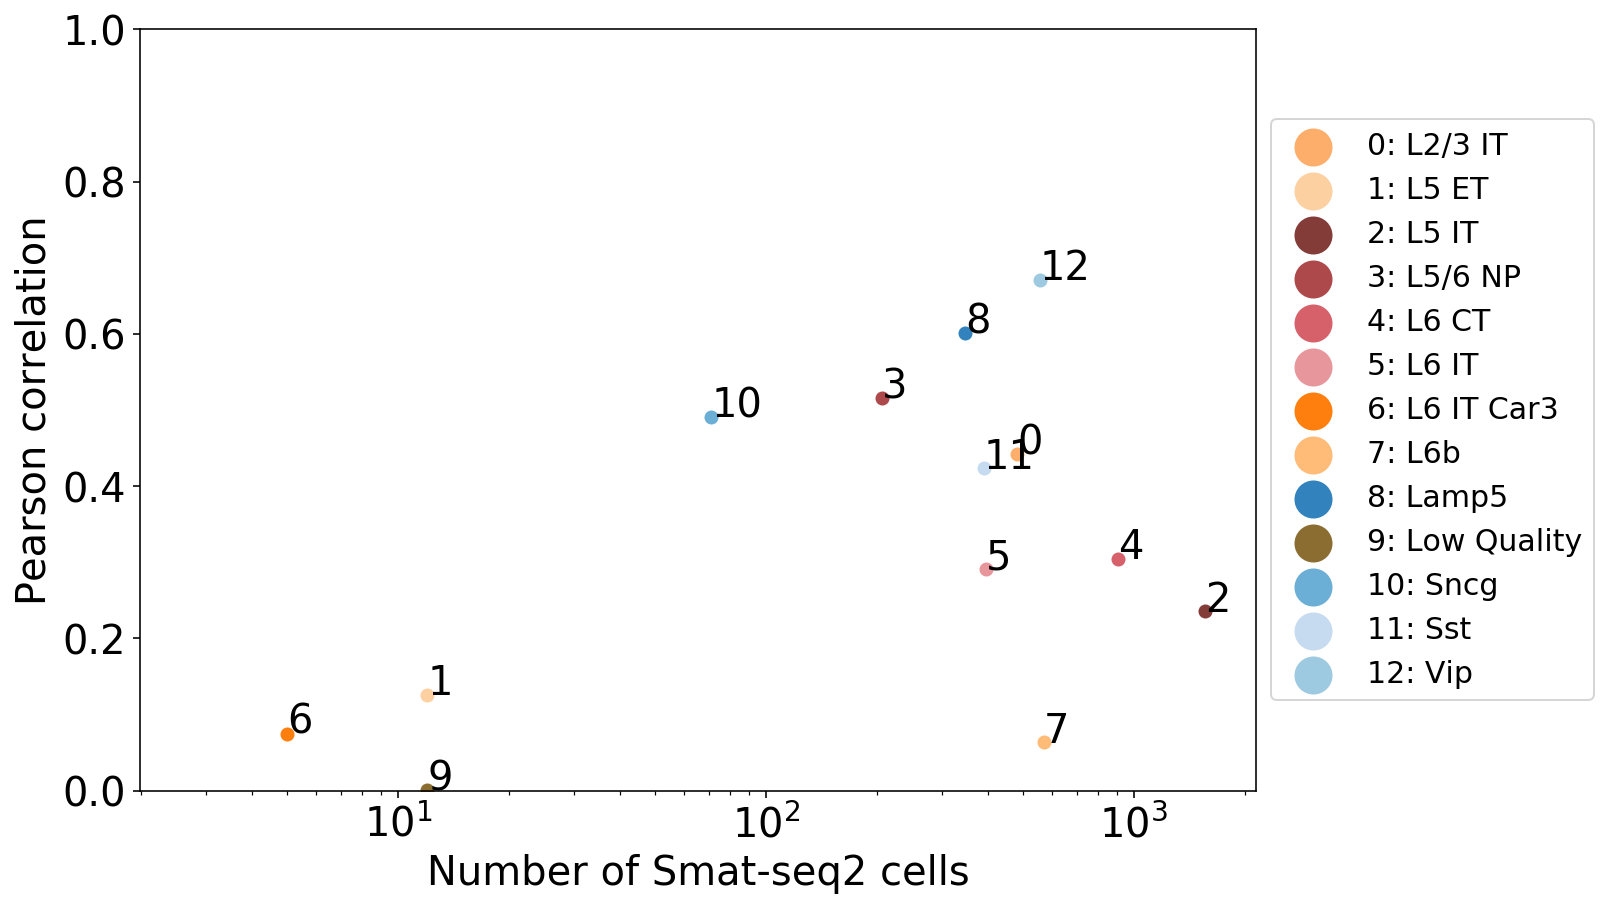

In [84]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(common_clusters):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smat-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [93]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

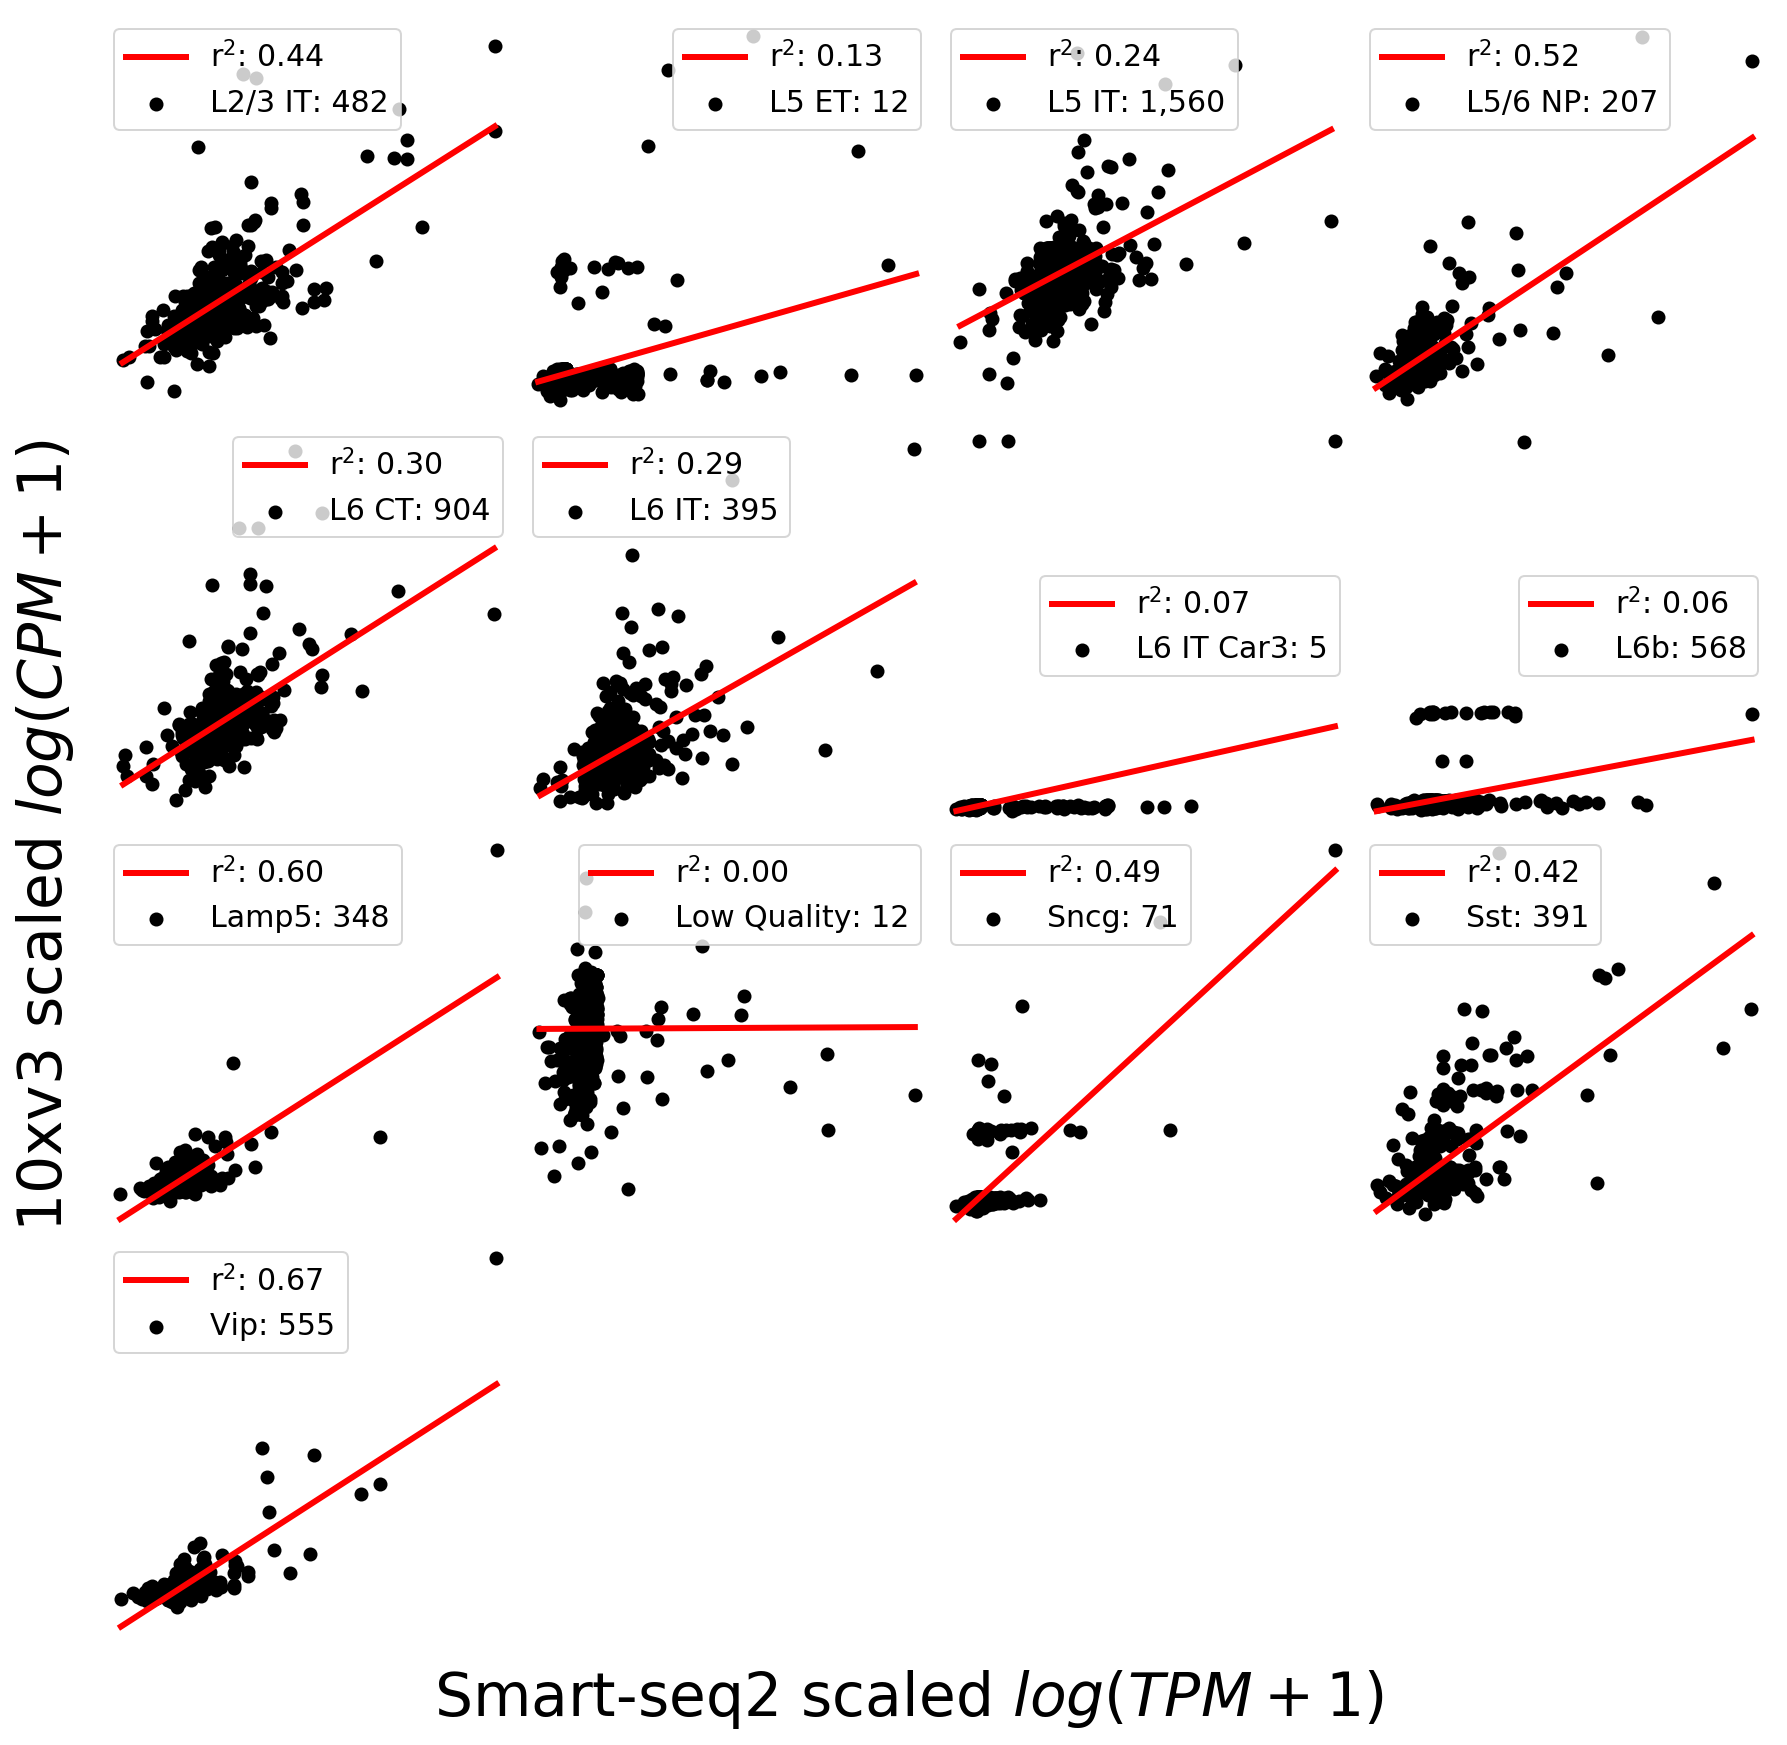

In [95]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(common_clusters))

for cidx, (ax, c) in enumerate(zip(axs, common_clusters)):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k")

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()

In [89]:
len(common_clusters)

13